In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from IPython.display import display
import random

colors = sns.color_palette("crest", 8)
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

# 1. Loading the data

In [2]:
# Reading the csv files into corresponding dataframes
aisles = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/aisles.csv')

departments = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/departments.csv')

order_products_prior = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/order_products__prior.csv')

order_products_train = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/order_products__train.csv')

orders = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/orders.csv')

# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(hours_of_day.keys(), hours_of_day.values())
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], 
                                             ordered=True, 
                                             categories=list(hours_of_day.values()))

# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(days_of_week.keys(), days_of_week.values())
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))

products = pd.read_csv('C:/Users/Admin/Desktop/20212/AppliedStatisticsProject20212/dataset/products.csv')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

        
# Reading the csv files into corresponding dataframes
# Then reduce their size to consume less memory
aisles = reduce_mem_usage(aisles)

departments = reduce_mem_usage(departments)

order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = reduce_mem_usage(order_products_train)

orders = reduce_mem_usage(orders)

products = reduce_mem_usage(products)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -159.9%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -92.7%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 137.03 MB
Memory usage after optimization is: 45.68 MB
Decreased by 66.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%


In [4]:
print('Shape of order_products_prior table: ', order_products_prior.shape)
order_products_prior.head(10)

Shape of order_products_prior table:  (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [5]:
print('Shape of order_products_train table: ', order_products_train.shape)
order_products_train.head(10)

Shape of order_products_train table:  (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [6]:
print('Shape of products table: ', products.shape)
print('Uniques products', products['product_name'].nunique())
products.head(20)

Shape of products table:  (49688, 4)
Uniques products 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [7]:
print('Shape of departments table: ', departments.shape)
departments.head(departments.shape[0])

Shape of departments table:  (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [8]:
print('Shape of aisles table: ', aisles.shape)
aisles.head(10)

Shape of aisles table:  (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [9]:
print('Shape of Orders table: ', orders.shape)
orders.head(12)

Shape of Orders table:  (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,Monday,08:00 AM,NaN
1,2398795,1,prior,2,Tuesday,07:00 AM,15.0
2,473747,1,prior,3,Tuesday,12:00 PM,21.0
3,2254736,1,prior,4,Wednesday,07:00 AM,29.0
4,431534,1,prior,5,Wednesday,03:00 PM,28.0
5,3367565,1,prior,6,Monday,07:00 AM,19.0
6,550135,1,prior,7,Sunday,09:00 AM,20.0
7,3108588,1,prior,8,Sunday,02:00 PM,14.0
8,2295261,1,prior,9,Sunday,04:00 PM,0.0
9,2550362,1,prior,10,Wednesday,08:00 AM,30.0


In [10]:
orders.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,Monday,08:00 AM,NaN
1,2398795,1,prior,2,Tuesday,07:00 AM,15.0
2,473747,1,prior,3,Tuesday,12:00 PM,21.0
3,2254736,1,prior,4,Wednesday,07:00 AM,29.0
4,431534,1,prior,5,Wednesday,03:00 PM,28.0
5,3367565,1,prior,6,Monday,07:00 AM,19.0
6,550135,1,prior,7,Sunday,09:00 AM,20.0
7,3108588,1,prior,8,Sunday,02:00 PM,14.0
8,2295261,1,prior,9,Sunday,04:00 PM,0.0
9,2550362,1,prior,10,Wednesday,08:00 AM,30.0


# 2. Exploratory data analysis

In [11]:
print("The number of products: ", products.shape[0])
print("The number of users: ", orders['user_id'].nunique())
print("The number of orders", orders.shape[0])

The number of products:  49688
The number of users:  206209
The number of orders 3421083


Number of prior orders:  3214874
Number of train orders:  131209
Number of test orders:  75000


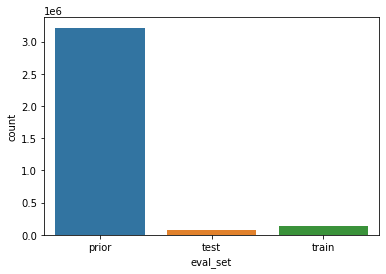

In [12]:
# Count of prior, train, test orders given in the data
print("Number of prior orders: ", orders[orders['eval_set'] == "prior"].shape[0])
print("Number of train orders: ", orders[orders['eval_set'] == "train"].shape[0])
print("Number of test orders: ", orders[orders['eval_set'] == "test"].shape[0])

sns.countplot(x='eval_set', data=orders)
plt.show()

### 2.1 ****When are people most likely to order products****?

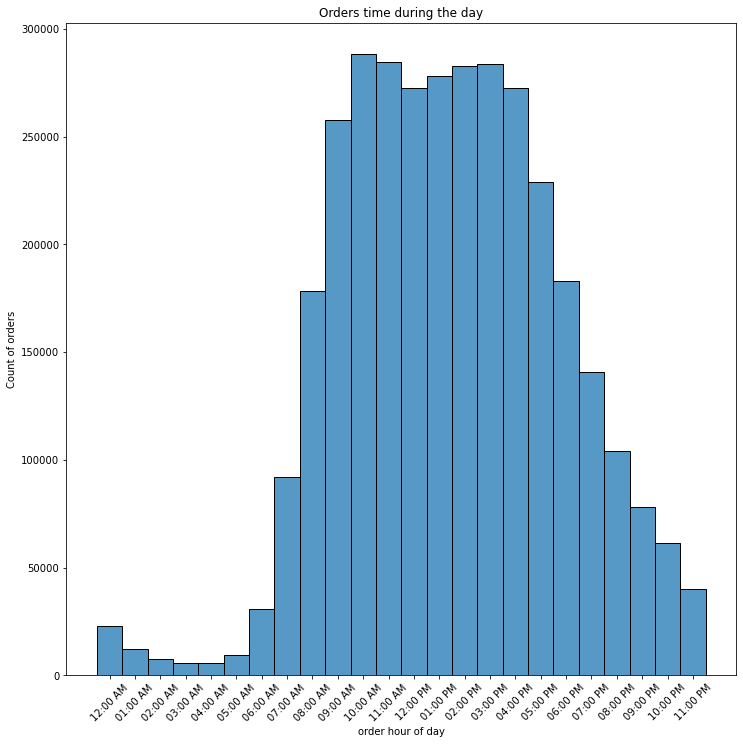

In [13]:
plt.figure(figsize=(12,12))
sns.histplot(data=orders, x="order_hour_of_day")
plt.xlabel('order hour of day')
plt.xticks(rotation= 45)
plt.ylabel('Count of orders')
plt.title('Orders time during the day')
plt.show()

Most orders are placed from 9 a.m to 5 p.m

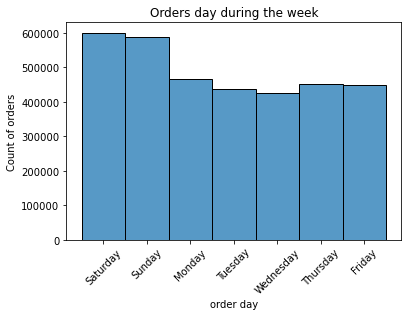

In [14]:
sns.histplot(data=orders, x="order_dow")
plt.xlabel('order day')
plt.xticks(rotation= 45)
plt.ylabel('Count of orders')
plt.title('Orders day during the week')
plt.show()

The number of orders are pretty stable during the weekdays (around 43000 orders per day). In the weekend, this number jumped up to around 60000 orders.

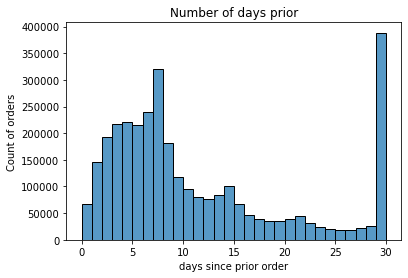

In [15]:
sns.histplot(data=orders, x='days_since_prior_order', bins = 30)
plt.xlabel('days since prior order')
plt.ylabel('Count of orders')
plt.title('Number of days prior')
plt.show()

We can see that there are many orders that are 30 days since prior order, this is because all the values > 30 are coered to 30.

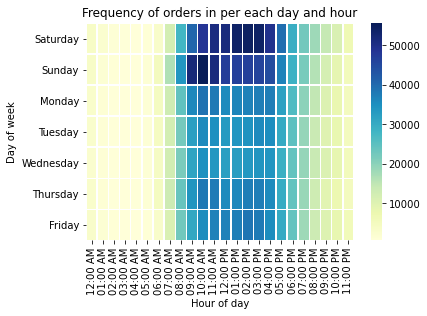

In [16]:
# Heatmap of the count of orders in each day with each hour
groupeddf = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].agg('count').reset_index().rename(columns={'order_id':'orders_count'})
heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'orders_count')

ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Frequency of orders in per each day and hour')
plt.ylabel('Day of week')
plt.xlabel('Hour of day')
plt.show()

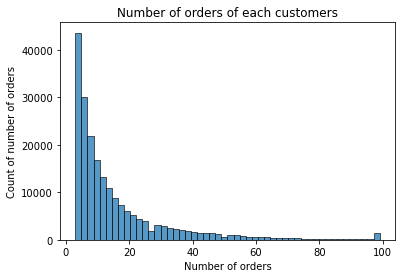

In [17]:
sns.histplot(data=orders[orders['eval_set']=='prior'].groupby('user_id')['order_id'].agg('count').reset_index(), x='order_id', bins = 50)
plt.xlabel('Number of orders')
plt.ylabel('Count of number of orders')
plt.title('Number of orders of each customers')
plt.show()

In [18]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = order_products['order_id'].nunique()
print('Count of total orders: ', total_orders)

order_products.head()

Count of total orders:  3346083


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,Wednesday,10:00 AM,9.0,dairy eggs,yogurt
1,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,56463,train,41,Tuesday,08:00 AM,14.0,dairy eggs,yogurt
2,170,8153,6,0,Plain Non-Fat Greek Yogurt,120,16,182389,train,7,Saturday,01:00 PM,14.0,dairy eggs,yogurt
3,631,9203,13,1,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt
4,631,15842,14,1,Dairy Free Coconut Milk Yogurt Alternative,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt


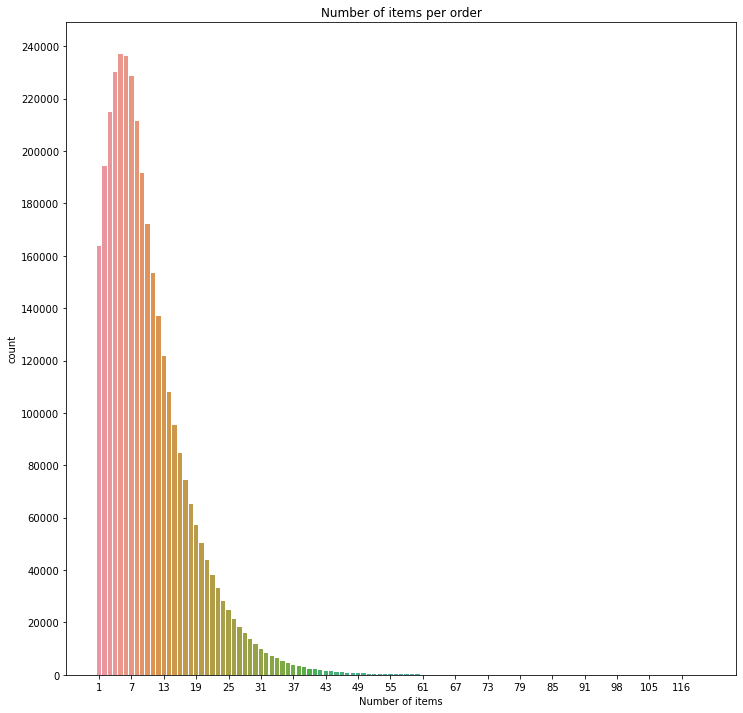

In [19]:
order_products_grouped = order_products.groupby('order_id')['product_id'].agg('count').reset_index()
plt.figure(figsize=(12,12))

sns.countplot(x='product_id', data=order_products_grouped)
plt.locator_params(nbins=20)

plt.title('Number of items per order')
plt.xlabel('Number of items')
plt.show()

###  ****2.2 Products analysis****

<BarContainer object of 10 artists>

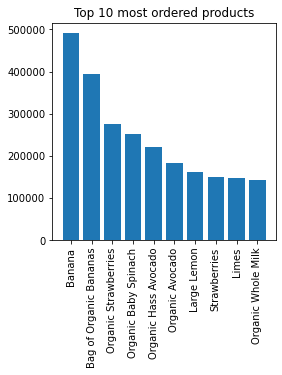

In [20]:
order_products_grouped_products = order_products.groupby("product_name")['user_id'].agg('count').reset_index().rename(columns = {"user_id":"number_of_orders"})
top_products = order_products_grouped_products.nlargest(n=10, columns=['number_of_orders'])
plt.figure(figsize=(4,4))
plt.xticks(rotation= 90)
plt.title('Top 10 most ordered products')

plt.bar(top_products["product_name"], top_products["number_of_orders"])

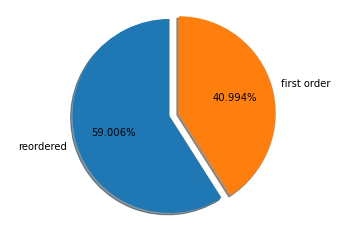

In [21]:
order_df = order_products['reordered'].value_counts().to_frame().reset_index().replace({1:"reordered", 0:"first order"}).rename(columns = {"index":"order_type", "reordered":"number_of_times"})
explode = [0,0.1]
fig1, ax1 = plt.subplots()
ax1.pie(order_df['number_of_times'], explode=explode, labels=order_df["order_type"], autopct='%1.3f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

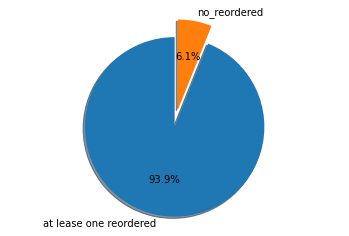

In [22]:
groupeddf = order_products.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0

# Count of non-first orders
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# Ratio of non-first orders containing no previously ordered products vs containing at least one previously ordered products
groupeddf = groupeddf[groupeddf.order_number != 1]
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
no_reordered_count = groupeddf['no_reordered'].value_counts()/non_first_orders_count * 100

no_reordered_count.head()

explode = [0,0.2]
fig1, ax1 = plt.subplots()
ax1.pie(no_reordered_count, explode=explode, labels=["at lease one reordered", "no_reordered"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values)
# ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])
# plt.title('Percentage of orders having no reordered products')
# plt.ylabel('Percentage %')
# plt.show()

Most orders after the first order have products that are reordered, which infer that customers have a high tendency to rebuy products that they have already ordered and used before. 

In [23]:
count_of_reordered_products = order_products.groupby(['order_id'], as_index=False)['reordered'].sum()
count_of_reordered_products['count_of_reordered_products'] = count_of_reordered_products['reordered']

reordered_products_count_histogram = count_of_reordered_products.groupby(['count_of_reordered_products'], as_index=False).count()
reordered_products_count_histogram['count_of_orders'] = reordered_products_count_histogram['reordered']
reordered_products_count_histogram['percentage_of_this_reordered_count'] = (reordered_products_count_histogram['count_of_orders']/total_orders) * 100
reordered_products_count_histogram = reordered_products_count_histogram[['count_of_reordered_products','count_of_orders','percentage_of_this_reordered_count']]
# Filter reorders counts occuring by prob less than 0.5% 
mask = reordered_products_count_histogram['percentage_of_this_reordered_count'] > 0.5
reordered_products_count_histogram = reordered_products_count_histogram[mask].sort_values(by=['percentage_of_this_reordered_count'], ascending=False)

reordered_products_count_histogram

# plt.figure(figsize=(12,12))

# sns.barplot(x=reordered_products_count_histogram['count_of_reordered_products'], y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values
#         )
# plt.ylabel('Percentage of having x count of reorders')
# plt.xlabel('Count of re-ordered products per basket')
# plt.title('Percentage of orders containing x count of reorders')
# plt.show()

,count_of_reordered_products,count_of_orders,percentage_of_this_reordered_count
0,0.0,397115,11.868056
2,2.0,345543,10.326791
1,1.0,343396,10.262626
3,3.0,325774,9.735981
4,4.0,293718,8.777965
5,5.0,256950,7.679128
6,6.0,220682,6.595234
7,7.0,187656,5.608229
8,8.0,158443,4.735178
9,9.0,132098,3.947840


<BarContainer object of 10 artists>

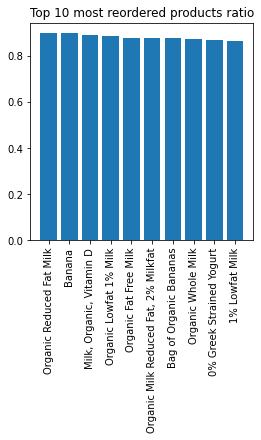

In [24]:
# For each product what is its probability to be reordered.
# We don't consider the first order of the user because 100% it won't contain any prev. ordered products.

non_first_orders_Mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_Mask].groupby('product_name').agg({'order_id':'count','reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio', 'order_id':'orders_count'})

# Filter products under 10000 order count
groupeddf = groupeddf[groupeddf['orders_count']>10000]
# Sort by the products having highest prob to be reordered
groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)
groupeddf = groupeddf.nlargest(n=10, columns=['reordered_ratio'])
plt.figure(figsize=(4,4))
plt.xticks(rotation= 90)
plt.title('Top 10 most reordered products ratio')

plt.bar(groupeddf["product_name"], groupeddf["reordered_ratio"])

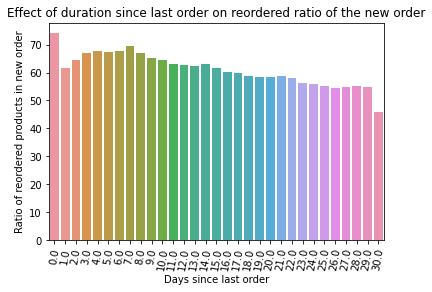

In [25]:
groupeddf = order_products.groupby(['days_since_prior_order']).agg({'reordered': 'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()
sns.barplot(x=groupeddf['days_since_prior_order'], y=groupeddf['reordered_ratio']*100)
plt.ylabel('Ratio of reordered products in new order')
plt.xlabel('Days since last order')
plt.xticks(rotation=80)
plt.title('Effect of duration since last order on reordered ratio of the new order')
plt.show()

74% of products bought at the same day of prev order are reorders and 69% of products bought after 1 week of prev order, are reorders

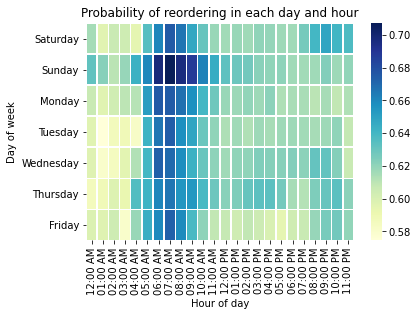

In [26]:
# Heatmap on the propability of non-new users to reorder for each day each hour
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['order_dow', 'order_hour_of_day']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'reordered_ratio')

ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Probability of reordering in each day and hour')
plt.ylabel('Day of week')
plt.xlabel('Hour of day')
plt.show()

Customer usually reorder products around 6AM to 8AM (especially on Sunday)

### 2.3 Departments and Aisles analysis¶


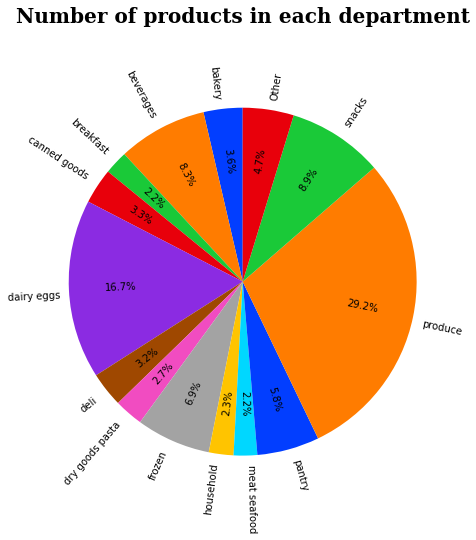

In [27]:

data = order_products.groupby(['department']).agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'products_count'})
data['products_percentage'] = data['products_count']/data['products_count'].sum()*100

palette_color = sns.color_palette('bright')

other = data[data['products_percentage'] < 2]
new_data = data[data['products_percentage'] >= 2]

other_data = pd.DataFrame({'department':['Other'], 'products_count':[other['products_count'].sum()], 'products_percentage':[other['products_count'].sum()/data['products_count'].sum()*100]})
# new_data.append(other_data, ignore_index = True)
final_df = pd.concat([new_data, other_data], ignore_index = True)
final_df

fdict = {
    'size': 20,
    'weight': 'heavy',
    'family': 'serif',
}

patches, labels, pct_texts = plt.pie(final_df['products_count'], labels =final_df['department'], colors = palette_color, autopct='%.1f%%', radius=2,  pctdistance=0.7, labeldistance=1.05, startangle=90, rotatelabels=True)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title('Number of products in each department', fdict, pad=150)

plt.show()

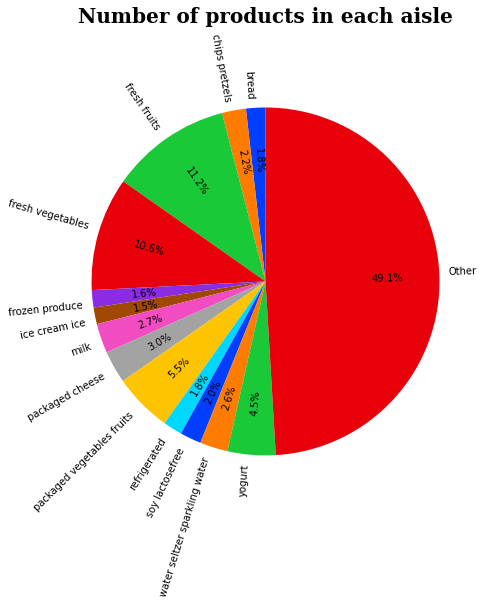

In [28]:
data = order_products.groupby(['aisle']).agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'products_count'})
data['products_percentage'] = data['products_count']/data['products_count'].sum()*100

palette_color = sns.color_palette('bright')

other = data[data['products_percentage'] < 1.5]
new_data = data[data['products_percentage'] >= 1.5]

other_data = pd.DataFrame({'aisle':['Other'], 'products_count':[other['products_count'].sum()], 'products_percentage':[other['products_count'].sum()/data['products_count'].sum()*100]})
# new_data.append(other_data, ignore_index = True)
final_df = pd.concat([new_data, other_data], ignore_index = True)

fdict = {
    'size': 20,
    'weight': 'heavy',
    'family': 'serif',
}


patches, labels, pct_texts = plt.pie(final_df['products_count'], labels =final_df['aisle'], colors = palette_color, autopct='%.1f%%', radius=2,  pctdistance=0.7, labeldistance=1.05, startangle=90, rotatelabels=True)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title('Number of products in each aisle', fdict, pad=150)
plt.show()

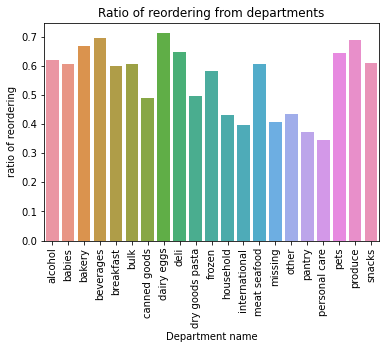

In [29]:
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['department']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})

groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)
sns.barplot(x='department', y='reordered_ratio', data=groupeddf)

plt.title('Ratio of reordering from departments')
plt.ylabel('ratio of reordering')
plt.xticks(rotation=90)
plt.xlabel('Department name')
plt.show()

<Figure size 1440x720 with 0 Axes>

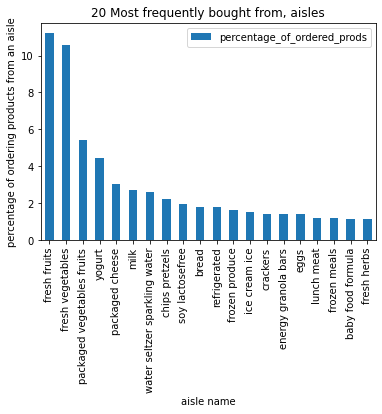

In [30]:
# From All ordered products, the count of contribution of each aisle
# Group by the count of ordering from an aisle
total_ordered_products = order_products.shape[0]
groupeddf = order_products.groupby(['aisle'], as_index=False).agg({'aisle_id':'count'}).rename(columns={'aisle_id':'count_of_ordered_prods'})
groupeddf['percentage_of_ordered_prods'] = groupeddf['count_of_ordered_prods']/total_ordered_products*100
groupeddf = groupeddf.sort_values(by=['count_of_ordered_prods'], ascending=False)
fig = plt.figure(figsize = (20, 10))
groupeddf.iloc[:20].plot.bar(x='aisle', y='percentage_of_ordered_prods')
plt.ylabel('percentage of ordering products from an aisle')
plt.xlabel('aisle name')
plt.xticks(rotation=90)
plt.title('20 Most frequently bought from, aisles')
plt.show()

<Figure size 432x432 with 0 Axes>

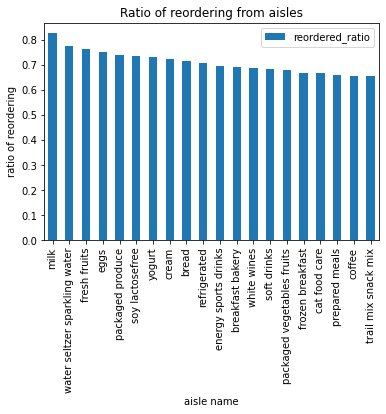

In [31]:
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['aisle']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
plt.figure(figsize = (6,6))

groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)
groupeddf.iloc[:20].plot.bar(x='aisle', y='reordered_ratio')
plt.title('Ratio of reordering from aisles')
plt.ylabel('ratio of reordering')
plt.xticks(rotation=90)
plt.xlabel('aisle name')
plt.savefig("output.jpg")
plt.show()
